In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import norm
from scipy.special import erfc, gamma
from jackknife import *
from spectral_density import *
import mpmath as mpmath
mpmath.mp.dps = 15

In [2]:
data = open("out/vector/data/fits/direct_fit_double.txt")
lines = data.readlines()
data.close()

par = []
for l in lines:
    t = l.split()
    if int(t[0]) == 10:
        for i in range(4):
            par.append(t[1 + 2*i])
        break
par = mpmath.matrix(par)

data = open("out/vector/data/fits/cov.txt")
cov = mpmath.matrix(len(par), len(par))
for i in range(len(par)):
    for j in range(len(par)):
        cov[i, j] = mpmath.mpf(data.readline().split()[0])
data.close()

corr_func = Double_exp()

times = range(1, 48)
corr_fit = mpmath.matrix(len(times), 1)
cov_corr_fit = mpmath.matrix(len(times), len(times))
for t1 in times:
    corr_fit[t1-1] = corr_func.f(mpmath.mpf(t1), par)
    for t2 in times:
        cov_corr_fit[t1-1, t2-1] = corr_func.cov_matrix(mpmath.mpf(t1), mpmath.mpf(t2), par, cov)

par_np = []
for i in par:
    par_np.append(float(i))
    
cov_np = np.array(cov.tolist())
for i in range(len(cov_np[0, :])):
    for j in range(len(cov_np[0, :])):
        cov_np[i, j] = float(cov_np[i, j])

In [3]:
df = open("out/vector/data/correlators/run_vector_folded_ml_4.txt", "r")
jf = open("out/vector/data/correlators/run_vector_jack.txt", "r")

d = df.readlines()

corr_jack = []
for line in d:
    jack = np.zeros(25)
    for i in range(25):
        jack[i]  = float(jf.readline())
    corr_jack.append(Jackknife())
    corr_jack[-1].mean = float((line.split())[0])
    corr_jack[-1].jack = jack
        
df.close()
jf.close()

corr_full = np.zeros(len(corr_jack))
cov_corr_full = np.zeros((len(corr_jack), len(corr_jack)))
for t_a in range(len(corr_jack)):
    corr_full[t_a] = corr_jack[t_a].mean
    for t_b in range(len(corr_jack)):
        cov_corr_full[t_a, t_b] = corr_jack[t_a].covariance(corr_jack[t_b])

corr_full = mpmath.matrix(corr_full[1:])
cov_corr_full = mpmath.matrix(cov_corr_full[1:, 1:])

In [ ]:
def a_func(t1, t2, w0):
    return np.exp(-w0 * (t1 + t2))/(t1 + t2)

def a_mat(t_max, w0, alpha):
    A = np.zeros((t_max, t_max))
    for i in range(t_max):
        for j in range(t_max):
            A[i, j] = a_func(i+1, j+1, w0)
    
    return np.linalg.inv(A + alpha * np.identity(t_max))

def b_v(w, t_max):
    b = np.zeros(0)
    for i in range(t_max):
        b = np.append(b, np.exp(-(i + 1)*w))

/data/knuth/home/dtoniolo/Analysis_spectral_densities/spectral_density.py:258: RuntimeWarning: invalid value encountered in power
  return (w**(-0.5 + s*1.0j)/np.sqrt(2*np.pi))
/data/knuth/home/dtoniolo/Analysis_spectral_densities/spectral_density.py:261: RuntimeWarning: overflow encountered in cosh
  return np.pi/(np.pi + a*np.cosh(np.pi * s))
/data/knuth/home/dtoniolo/Analysis_spectral_densities/spectral_density.py:265: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, 0.0, +np.inf)[0]


Text(0.5, 1.0, '$\\omega_* = 810.0$')

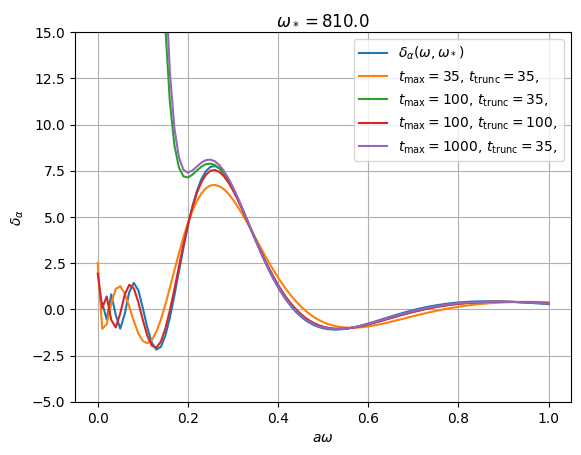

In [ ]:
x_grid = np.linspace(0, 1, 101)

y = []
for x in x_grid:
    y.append(SDan().delta(x, 3*270*0.065/197.3, 1e-8))
plt.plot(x_grid, y, label = r"$\delta_\alpha(\omega, \omega_*)$")

times = [[35, 35], [100, 35], [100, 100], [1000, 35]]
t_trunc = [35, 35]
for t in times:
    A = a_mat(t[0], 0.0, 1e-8)
    y1 = []
    for x in x_grid:
        y1.append(b_v(x, t[1]).T @ A[:t[1],:t[0]] @ b_v(3*270*0.065/197.3, t[0]))
    plt.plot(x_grid, y1, label=r"$t_\mathrm{max} = $" + r"${}$, ".format(t[0]) + r"$t_\mathrm{trunc} = $" + r"${}$, ".format(t[1]))


plt.ylim(-5, 15)
plt.legend()
plt.grid()
plt.xlabel(r"$a\omega$")
plt.ylabel(r"$\delta_\alpha$")
plt.title(r"$\omega_* = {}$".format(3.*270))